List of kart numbers and its average best lap time, from the last 30 days

In [38]:
import sqlite3
import pandas as pd
from datetime import timedelta
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('../scraping/scraping_data.db')
cursor = conn.cursor()

In [3]:
df = pd.read_sql_query("select * from params_to_scrap where fetched is True", conn)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
end_date = df['date'].max()
init_date = end_date - timedelta(days=30)
print(end_date, init_date)

2023-12-31 00:00:00 2023-12-01 00:00:00


In [60]:
query = f"""
with last_30_days as (
    select *
    from
        (select *,
        date(year || '-' || substr('00' || month, -2) || '-' || substr('00' || day, -2)) as date
        from params_to_scrap
        where 
        fetched is True) t
    where date >= '{init_date.strftime('%Y-%m-%d')}'
)
select 
btr.car_number,
brt.track,
btr.best_lap_time
from last_30_days l
left join bronze_racing_tries brt on brt.params_id = l.id
left join bronze_try_results btr on btr.uid = brt.uid
where 
btr.best_lap_time is not Null and
btr.best_lap_time != ''
"""
df = pd.read_sql_query(query, conn)
def gen_time_in_seconds(string_value):
    splited_value = [int(x) for x in re.split(r'\.|:', string_value)]
    time = 0
    if len(splited_value) == 3:
        time += splited_value[0]*60
        time += splited_value[1]
        time += splited_value[2]/1000
    elif len(splited_value) == 2:
        time += splited_value[0]
        time += splited_value[1]/1000
    return time
df['best_lap_in_seconds'] = df['best_lap_time'].apply(gen_time_in_seconds)
del df['best_lap_time']
average_lap_time_df = df[df['track'] == 'CIRCUITO 101'].groupby('car_number')['best_lap_in_seconds'].agg(['mean', 'count']).reset_index()
average_lap_time_df = average_lap_time_df.sort_values(by='mean', ascending=False)
average_lap_time_df[average_lap_time_df['count'] > 30]

,car_number,mean,count
34,034,69.991588,68
0,000,69.549180,50
15,015,69.199377,77
30,030,68.654137,73
60,060,68.579612,49
...,...,...,...
55,055,64.838229,48
58,058,64.835514,74
13,013,64.629648,91
26,026,64.461222,81


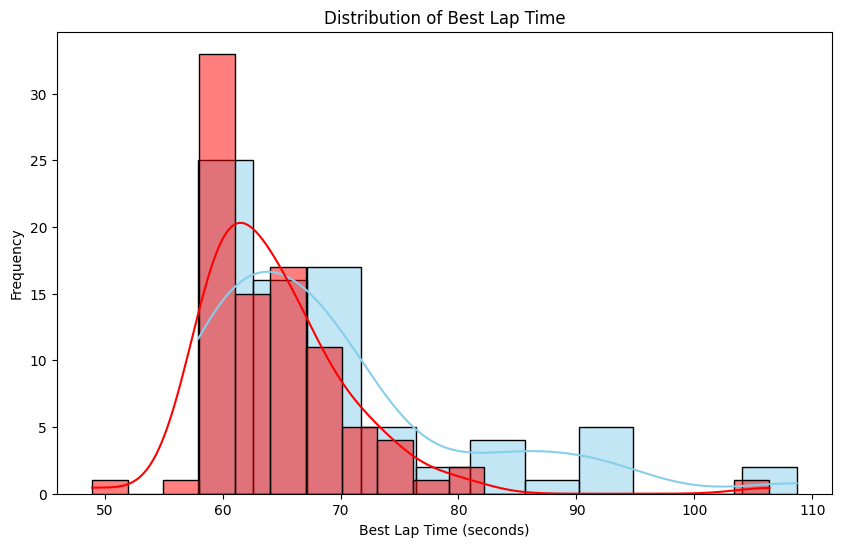

In [62]:
def car_filter(car_number):
    return (df['track'] == 'CIRCUITO 101') & (df['car_number'] == car_number)

plt.figure(figsize=(10, 6))
sns.histplot(df[car_filter('015')]['best_lap_in_seconds'], kde=True, color='skyblue')
sns.histplot(df[car_filter('013')]['best_lap_in_seconds'], kde=True, color='red')
plt.xlabel('Best Lap Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Best Lap Time')
plt.show()